In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import torch
import torchvision.transforms as transforms
from torch import nn, optim  # 导入神经网络与优化器对应的类
import torch.nn.functional as F 
from torchvision import datasets, transforms ## 导入数据集与数据预处理的方法

In [4]:
# 数据预处理：标准化图像数据，使得灰度数据在-1到+1之间
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# 下载Fashion-MNIST训练集数据，并构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序
trainset = datasets.FashionMNIST('dataset/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 下载Fashion-MNIST测试集数据，并构建测试集数据载入器trainloader,每次从测试集中载入64张图片，每次载入都打乱顺序
testset = datasets.FashionMNIST('dataset/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

这张图片对应的标签是 汗衫


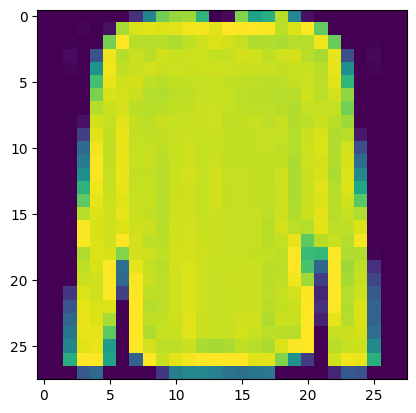

In [5]:
image, label = next(iter(trainloader))

# image图片中有64张图片，我们查看索引为2的图片
imagedemo = image[3]
imagedemolabel = label[3]

imagedemo = imagedemo.reshape((28,28))

import matplotlib.pyplot as plt

plt.imshow(imagedemo)

labellist = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
print(f'这张图片对应的标签是 {labellist[imagedemolabel]}')

In [18]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
        #构造Dropout方法，随即掐死百分之二十的神经元，防止过拟合
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1) ##定义正向传播函数
        
        x = F.dropout(F.relu(self.fc1(x)))  ##内部添加正向修正函数
        x = F.dropout(F.relu(self.fc2(x)))
        x = F.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [19]:
# 对上面定义的Classifier类进行实例化
model = Classifier()

# 定义损失函数为负对数损失函数
criterion = nn.NLLLoss()  ##将损失函数降最低

# 优化方法为Adam梯度下降方法，学习率为0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)
##（结合动量算法）
# 对训练集的全部数据学习15遍，这个数字越大，训练时间越长
epochs = 15

# 将每次训练的训练误差和测试误差存储在这两个列表里，后面绘制误差变化折线图用
train_losses, test_losses = [], []

print('开始训练')
for e in range(epochs):
    running_loss = 0
    
    # 对训练集中的所有图片都过一遍
    for images, labels in trainloader:
        # 将优化器中的求导结果都设为0，否则会在每次反向传播之后叠加之前的
        optimizer.zero_grad()    ##求导结果都设为0
        
        # 对64张图片进行推断，计算损失函数，反向传播优化权重，将损失求和
        log_ps = model(images)   #正向传播
        loss = criterion(log_ps, labels)   #算出误差
        loss.backward()   #参数反向传播，优化迭代
        optimizer.step()
        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0
        # 测试的时候不需要开自动求导和反向传播
        with torch.no_grad():
            # 关闭Dropout
            model.eval()
            
            # 对测试集中的所有图片都过一遍
            for images, labels in testloader:
                # 对传入的测试集图片进行正向推断、计算损失，accuracy为测试集一万张图片中模型预测正确率
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                # 等号右边为每一批64张测试图片中预测正确的占比
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # 恢复Dropout
        model.train()
        # 将训练误差和测试误差存在两个列表里，后面绘制误差变化折线图用
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("训练集学习次数: {}/{}.. ".format(e+1, epochs),
              "训练误差: {:.3f}.. ".format(running_loss/len(trainloader)),
              "测试误差: {:.3f}.. ".format(test_loss/len(testloader)),
              "模型分类准确率: {:.3f}".format(accuracy/len(testloader)))

开始训练
训练集学习次数: 1/15..  训练误差: 0.853..  测试误差: 0.752..  模型分类准确率: 0.720
训练集学习次数: 2/15..  训练误差: 0.700..  测试误差: 0.707..  模型分类准确率: 0.759
训练集学习次数: 3/15..  训练误差: 0.666..  测试误差: 0.704..  模型分类准确率: 0.777
训练集学习次数: 4/15..  训练误差: 0.649..  测试误差: 0.665..  模型分类准确率: 0.779
训练集学习次数: 5/15..  训练误差: 0.637..  测试误差: 0.678..  模型分类准确率: 0.767
训练集学习次数: 6/15..  训练误差: 0.628..  测试误差: 0.691..  模型分类准确率: 0.775
训练集学习次数: 7/15..  训练误差: 0.632..  测试误差: 0.677..  模型分类准确率: 0.779
训练集学习次数: 8/15..  训练误差: 0.631..  测试误差: 0.663..  模型分类准确率: 0.776
训练集学习次数: 9/15..  训练误差: 0.623..  测试误差: 0.688..  模型分类准确率: 0.774
训练集学习次数: 10/15..  训练误差: 0.623..  测试误差: 0.664..  模型分类准确率: 0.779
训练集学习次数: 11/15..  训练误差: 0.614..  测试误差: 0.667..  模型分类准确率: 0.785
训练集学习次数: 12/15..  训练误差: 0.625..  测试误差: 0.666..  模型分类准确率: 0.777
训练集学习次数: 13/15..  训练误差: 0.620..  测试误差: 0.682..  模型分类准确率: 0.777
训练集学习次数: 14/15..  训练误差: 0.615..  测试误差: 0.695..  模型分类准确率: 0.783
训练集学习次数: 15/15..  训练误差: 0.610..  测试误差: 0.637..  模型分类准确率: 0.792


In [20]:
import matplotlib.pyplot as plt


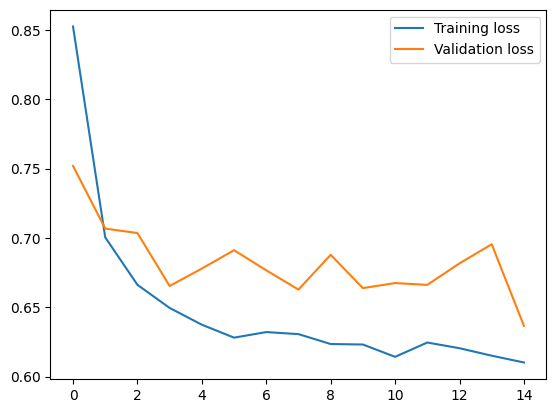

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

神经网络猜测图片里是 T恤，概率为60.344451665878296%


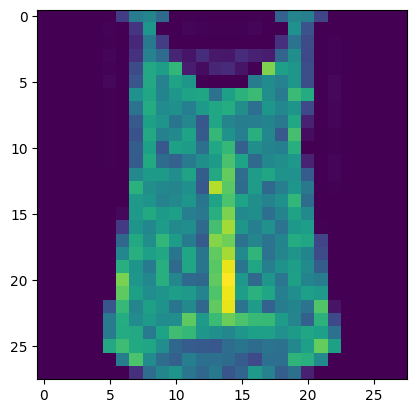

In [22]:
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.reshape((28,28)).numpy()
plt.imshow(img)

# 将测试图片转为一维的列向量
img = torch.from_numpy(img)
img = img.view(1, 784)

# 进行正向推断，预测图片所在的类别
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)
labellist = ['T恤','裤子','套衫','裙子','外套','凉鞋','汗衫','运动鞋','包包','靴子']
prediction = labellist[top_class]
probability = float(top_p)
print(f'神经网络猜测图片里是 {prediction}，概率为{probability*100}%')